In [1]:
import numpy as np
import pandas as pd
import pickle
import smogn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Objective

In this notebook, we will use another SMOTE pre-processing method and apply it to a slightly larger dataset. 

We take the video game sales dataset from kaggle (cited below) and aim to create a classification model which can classify if a game will have over 10 million sales. The dataset has 1907 rows, and a small fraction have sales surpassing 10 million units. Since it is a classification problem, SMOTER (explained in 4_small_data_methods notebook) will be used instead of SMOGN.

Since the purpose is to explore SMOTER on a different dataset, the focus will be interpreting the goodness of models on the original vs. SMOTER data. Therefore all steps for modeling are contained in this notebook as a short example notebook.


dataset: https://www.kaggle.com/datasets/thedevastator/discovering-hidden-trends-in-global-video-games

#### Read Data

In [2]:
sales = pd.read_csv('../data/video_game_sales.csv')

## Data Cleaning

In [3]:
# clean column names
sales.columns = [col.lower().replace(' ', '_') for col in sales.columns]

In [4]:
# examine data
sales.head(2)

,index,rank,game_title,platform,year,genre,publisher,north_america,europe,japan,rest_of_world,global,review
0,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00


In [5]:
# data shape
sales.shape

(1907, 13)

In [6]:
sales.dtypes

index              int64
rank               int64
game_title        object
platform          object
year             float64
genre             object
publisher         object
north_america    float64
europe           float64
japan            float64
rest_of_world    float64
global           float64
review           float64
dtype: object

1. We will first limit the data to relevant columns, which will be `genre`, `publisher`, `north_america`, `europe`, `japan`, `review`, `platform` and `rest_of_world` for explanatory variables
2. `global` is used to create our target $y$ variable.

In [7]:
# reset index
sales.reset_index(drop=True, inplace=True)
# stash away the name for later
sales_name = sales[['game_title']]
# drop unnecessary columns
sales.drop(columns=['index', 'rank', 'game_title', 'year'], inplace=True)

In [8]:
# drop null values
sales.isnull().sum()

platform         0
genre            0
publisher        2
north_america    0
europe           0
japan            0
rest_of_world    0
global           0
review           0
dtype: int64

In [9]:
sales = sales.loc[~sales['publisher'].isnull()].copy()

In [10]:
sales.shape

(1905, 9)

Next, we will look at outliers in the data using iqr method from 2_data_cleaning_eda notebook:

In [11]:
# define a function to find outliers
def iqr_method(df: pd.DataFrame, col: str):
    """
    finds outliers of df[col]
    """
    # define first quartile
    q1=df[col].quantile(0.25)
    # define third quartile
    q3=df[col].quantile(0.75)
    # define iqr as difference between first and third quartiles
    iqr = q3 - q1
    # identify outliers which fall 1.5 * iqr below q1 or 1.5 * iqr above q3
    return df.loc[(df[col]<(q1-1.5*iqr))|(df[col]>(q3+1.5*iqr))]

In [12]:
# look at outliers for na, eu, jp, and other sales
print(f"number of outliers for eu sales: {len(iqr_method(df=sales, col='europe'))}")
print(f"number of outliers for na sales: {len(iqr_method(df=sales, col='north_america'))}")
print(f"number of outliers for jp sales: {len(iqr_method(df=sales, col='japan'))}")
print(f"number of outliers for other sales: {len(iqr_method(df=sales, col='rest_of_world'))}")

number of outliers for eu sales: 153
number of outliers for na sales: 149
number of outliers for jp sales: 264
number of outliers for other sales: 169


We look at histograms of the sales to see the outliers:

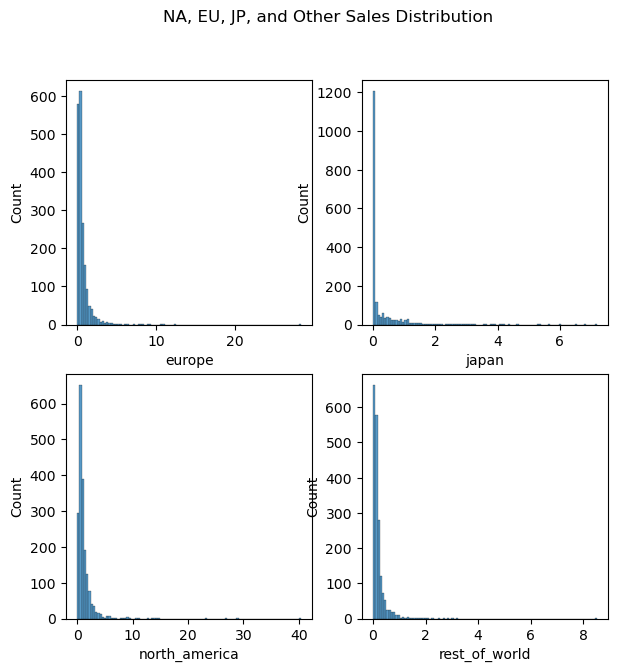

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('NA, EU, JP, and Other Sales Distribution')

sns.histplot(sales, x="europe", ax=axes[0, 0], bins=100)
sns.histplot(sales, x="north_america", ax=axes[1, 0], bins=100)
sns.histplot(sales, x="japan", ax=axes[0, 1], bins=100)
sns.histplot(sales, x="rest_of_world", ax=axes[1, 1], bins=100)
plt.show();

Since our targets of interest are video games which have very high sales, we will keep these outliers.

In [14]:
# look at outliers for review
iqr_method(df=sales, col='review')

,platform,genre,publisher,north_america,europe,japan,rest_of_world,global,review
99,Wii,Sports,505 Games,3.21,2.44,0.00,0.66,6.30,51.00
335,NES,Sports,Nintendo,0.73,0.10,2.35,0.02,3.20,39.00
417,PS,Platform,Sony Computer Entertainment,1.96,0.72,0.00,0.11,2.79,51.90
449,DS,Action,Disney Interactive Studios,1.59,0.80,0.00,0.26,2.64,45.00
501,Wii,Sports,Hudson Soft,1.09,0.82,0.29,0.24,2.45,53.04
...,...,...,...,...,...,...,...,...,...
1832,PS2,Action,Tecmo Koei,0.11,0.09,0.64,0.03,0.87,54.50
1856,DS,Misc,Pinnacle,0.00,0.79,0.00,0.06,0.85,42.00
1870,Wii,Sports,Take-Two Interactive,0.70,0.08,0.00,0.07,0.85,55.00
1881,PS,Sports,THQ,0.47,0.32,0.00,0.05,0.84,51.00


Since review has 83 outliers, we will drop them

In [15]:
# Since review has 83 outliers, we will drop them
sales = sales.loc[~sales.index.isin(iqr_method(df=sales, col='review').index)].copy()

Next, we will look at the correlation between our explanatory variables:

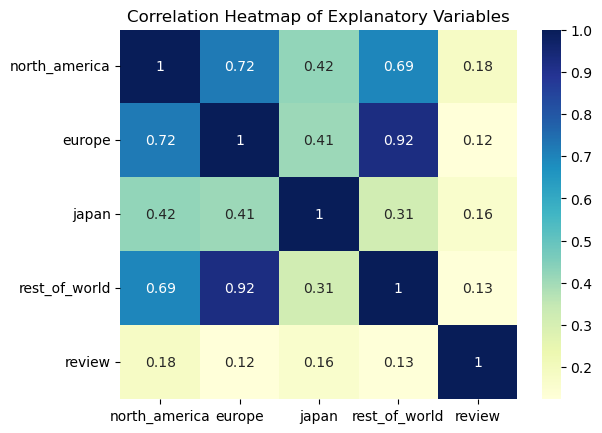

In [16]:
# create correlation heatmap
dataplot = sns.heatmap(sales[['north_america', 'europe', 'japan', 'rest_of_world', 'review']].corr(), 
                       cmap="YlGnBu", annot=True).set(title='Correlation Heatmap of Explanatory Variables')
plt.show();

Since europe and rest_of_world have high correlation, we drop rest_of_world:

In [17]:
sales.drop(columns=['rest_of_world'], inplace=True)

In [18]:
sales.reset_index(inplace=True, drop=True)

### Pre-Process and Modeling

In [19]:
sales.columns

Index(['platform', 'genre', 'publisher', 'north_america', 'europe', 'japan',
       'global', 'review'],
      dtype='object')

Next we will pre-process the data for modeling. Since this is a classification, we will first start with logistic regression (as it is interpretable) before exploring other methods.

In [20]:
# define new y var which is 1 if global sales are over 10 million games
sales['one_mil_game'] = np.where(sales['global']>=10, 1, 0)

In [21]:
sales['one_mil_game'].value_counts().to_frame()

,one_mil_game
0,1774
1,48


Since europe and north_america were very correlated to global sales, they were removed in order to make the classification harder.

In [22]:
# define X and y
X = sales[['platform', 'genre', 'publisher', 'japan', 'review']]
y = sales['one_mil_game']

In [23]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [24]:
# check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1366, 5), (456, 5), (1366,), (456,))

In [25]:
# check y mean
y_train.mean(), y_test.mean()

(0.02635431918008785, 0.02631578947368421)

In [26]:
# one hot encoder for categorical variables
# apply standard scaler for numeric variables

pipe_ohe_ss = ColumnTransformer([('scaler', StandardScaler(), ['japan', 'review']),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), ['platform', 'genre', 'publisher'])],
                                verbose_feature_names_out=False)

# fit ohe and ss
pipe_ohe_ss.fit(X_train)

# transform train and test X
X_train_t = pd.DataFrame(pipe_ohe_ss.transform(X_train).todense(), columns=pipe_ohe_ss.get_feature_names_out())
X_test_t = pd.DataFrame(pipe_ohe_ss.transform(X_test).todense(), columns=pipe_ohe_ss.get_feature_names_out())

C:\Users\rstop\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Defining logistic regression parameters to sweep over
logreg_params = {
    'penalty':['l1','l2'],
    'C':[0.6,0.8,1.0]
}
# GridSearching logistic regression classifiers
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params, n_jobs=-1)
logreg_grid.fit(X_train_t, y_train)
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid.score(X_train_t, y_train)}')
print(f'Testing accuracy: {logreg_grid.score(X_test_t, y_test)}')

Training accuracy: 0.9838945827232797
Testing accuracy: 0.9824561403508771


In [28]:
logreg_grid.best_params_

{'C': 0.8, 'penalty': 'l1'}

In [29]:
parameter_weight_df = pd.DataFrame(logreg_grid.best_estimator_.coef_[0], index = X_train_t.columns)
parameter_weight_df.columns = ['Weight']
parameter_weight_df.sort_values('Weight', ascending=False).head(10)

,Weight
platform_X360,1.747432
platform_Wii,1.360063
publisher_Activision,1.358550
japan,1.271065
genre_Shooter,1.067641
review,0.654372
publisher_Nintendo,0.207873
publisher_Hasbro Interactive,0.000000
publisher_Microprose,0.000000
publisher_Pacific Century Cyber Works,0.000000


Now, we perform SMOTER on the data as a pre-processing step to sample more of the cases we are interested in (blockbuster games where global sales were over 10 million units)

In [30]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_tf = pd.DataFrame(pipe_ohe_ss.transform(X).todense(), columns=pipe_ohe_ss.get_feature_names_out())
X_smote, y_smote = pipeline.fit_resample(X_tf, y)

C:\Users\rstop\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, random_state=901)

In [32]:
logreg_params_smote = {
    'penalty':['l1','l2'],
    'C':[0.01, 0.02, 0.03, 0.04]
}
# using gridsearch
logreg_grid_smote = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params_smote, n_jobs=-1)
logreg_grid_smote.fit(X_smote_train, y_smote_train)
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid_smote.score(X_smote_train, y_smote_train)}')
print(f'Testing accuracy: {logreg_grid_smote.score(X_smote_test, y_smote_test)}')

# pointing out that a lot of this code is from project 4 groupwork, pretty code from Bruno

Training accuracy: 0.9246231155778895
Testing accuracy: 0.943609022556391


In [33]:
logreg_grid_smote.best_params_

{'C': 0.02, 'penalty': 'l2'}

In [34]:
y_smote.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: one_mil_game, dtype: float64

In [35]:
y.value_counts(normalize=True)

0    0.973655
1    0.026345
Name: one_mil_game, dtype: float64

In [36]:
# accuracy of original model on smote sample:
print(f'Testing accuracy: {logreg_grid.score(X_smote_test, y_smote_test)}')

Testing accuracy: 0.9172932330827067


In [37]:
logreg_grid_smote.score(X_test_t, y_test)

0.9758771929824561

We look at confusion matrices applying both models to the original y_pred to see if the instances where `one_mil_game`=1 were predicted better:

In [38]:
# take random sample of data
sampled = sales.sample(frac=0.3, replace=True, random_state=1)

In [39]:
X_sampled = sampled[['platform', 'genre', 'publisher', 'japan', 'review']]
y_sampled = sampled['one_mil_game']

In [40]:
X_sampled_t = pd.DataFrame(pipe_ohe_ss.transform(X_sampled).todense(), columns=pipe_ohe_ss.get_feature_names_out())

C:\Users\rstop\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


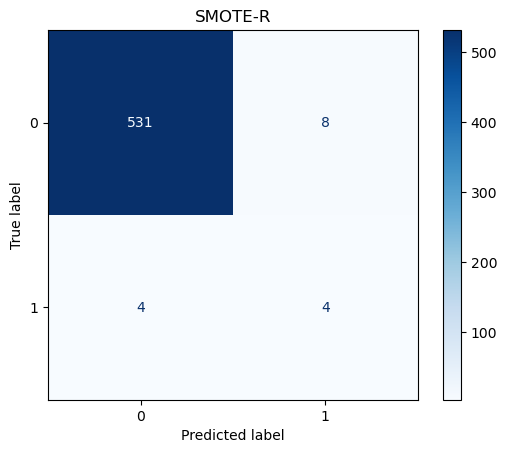

In [44]:
# plot for SMOTE model
cm = confusion_matrix(y_sampled, logreg_grid_smote.predict(X_sampled_t))
disp = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
disp.ax_.set_title("SMOTE-R");

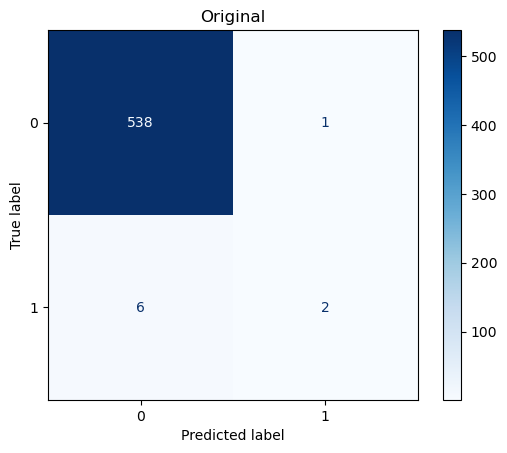

In [47]:
# plot for original model
cm2 = confusion_matrix(y_sampled, logreg_grid.predict(X_sampled_t))
disp2 = ConfusionMatrixDisplay(cm2).plot(cmap=plt.cm.Blues);
disp2.ax_.set_title("Original");

We see that out of the 8 cases where `one_mil_game`=1 in the random sample, the SMOTE-applied model classified 4 correctly while the original model classified 2 correctly.